In [94]:
# %load ../../misc/utils/import.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

from pandas_ods_reader import read_ods
import os

from scipy.stats import binom_test

#Display Settings
pw = 16
ph = 9
matplotlib.rcParams['figure.figsize'] = (pw, ph)

sns.set_style("whitegrid")

#Pandas Dsiplay
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

# import warnings
# warnings.filterwarnings('ignore')

In [95]:
#colors
aquam = '#46d4d1'
blue = '#45d4ff'
peach = '#f57542'
coral = '#eb4c34'
yellow = '#eef07d'

## Exploratory Data Anlysis of Traffic Accidents in Belgrade 

In [96]:
#Read df
input_dir = 'inputs'

file_names =[input_dir + '/' +  x for x in np.array(os.listdir(input_dir))]
#Columns are missing
columns = ['id', 'date', 'long', 'lat', 'acc_outcome' ,'acc_type', 'description']

df = read_ods(file_names[0], 1, columns=columns)
for fn in file_names[1:]:
    df = pd.concat([df, read_ods(fn, 1, columns=columns)])
print("Number of accidents {}".format(len(df)))

Number of accidents 69001


In [97]:
#Sample
print("Sample")
df.sample(5, random_state=23)

Sample


,id,date,long,lat,acc_outcome,acc_type,description
8086,1182809.0,"22.06.2017,17:30",20.4005,44.8328,Sa mat.stetom,SN SA PARKIRANIM VOZILIMA,Sudar sa parkiranim vozilom sa desne strane kolovoza
13379,1195037.0,"12.10.2017,00:05",20.5178,44.6857,Sa povredjenim,SN SA PARKIRANIM VOZILIMA,Ostali sudari sa parkiranim vozilom
8891,1223300.0,"02.07.2018,21:00",20.4911,44.8404,Sa mat.stetom,SN SA PARKIRANIM VOZILIMA,Sudar sa parkiranim vozilom sa leve strane kolovoza
883,1165433.0,"22.01.2017,04:10",20.4805,44.8037,Sa povredjenim,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Ostale nezgode sa najmanje dva vozila – suprotni smerovi bez skretanja
3261,1172877.0,"17.03.2017,19:40",20.3307,44.5819,Sa povredjenim,SN SA NAJMANjE DVA VOZILA – SKRETANjE ILI PRELAZAK,Najmanje dva vozila koja se kreću istim putem u suprotnim smerovima uz skretanje ulevo ispred drugog vozila


In [98]:
#Add dummy
df['count'] = 1

#Correct falty data
df['long'] = df['long'].astype('str').map(lambda x: x.replace(',','.'))
df['lat'] = df['lat'].astype('str').map(lambda x: x.replace(',','.'))

#Expolicit type cast
df['long'] = df['long'].astype('float')
df['lat'] = df['lat'].astype('float')

In [99]:
#To date-time
df['date'] = pd.to_datetime(df['date'])

#Sort by date
df = df.sort_values('date')

#Clip end
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime(2019, 1, 1) # 2 28
df = df[df['date'].between(start_date, end_date)]

#Month
df['month']  = df['date'].dt.month_name()

#Weekday
df['day_of_week'] = df['date'].dt.weekday_name

#Hour
df['hour']  = df['date'].dt.hour

print("Data from {} to {}".format(df['date'].min().date(), df['date'].max().date()))

Data from 2015-01-01 to 2018-12-31


In [100]:
#Check Duplicates
dupl_ids = df[df.duplicated(subset=['id'])]['id']

print('Check duplicates')
df.set_index('id').sort_index().loc[dupl_ids].head(4)

Check duplicates


,date,long,lat,acc_outcome,acc_type,description,count,month,day_of_week,hour
id,,,,,,,,,,
1103411.0,2015-09-24 13:45:00,7.446000e+06,4.919026e+06,Sa povredjenim,SN SA JEDNIM VOZILOM,Nezgoda sa jednim vozilom i prevrtanjem,1,September,Thursday,13
1103411.0,2015-09-24 13:45:00,7.446000e+06,4.919026e+06,Sa povredjenim,SN SA JEDNIM VOZILOM,Nezgoda sa jednim vozilom РђЊ silazak udesno sa kolovoza na pravcu,1,September,Thursday,13
1115900.0,2016-01-01 03:45:00,2.048094e+01,4.480309e+01,Sa povredjenim,SN SA PARKIRANIM VOZILIMA,Sudar sa parkiranim vozilom sa leve strane kolovoza,1,January,Friday,3
1115900.0,2016-01-01 03:45:00,2.048094e+01,4.480309e+01,Sa povredjenim,SN SA NAJMANjE DVA VOZILA – BEZ SKRETANjA,Najmanje dva vozila – čeoni sudar,1,January,Friday,3


In [101]:
#Drop Duplictates
print("Before duplicates removal {}".format(len(df)))
df = df.drop_duplicates(subset=['id'])
print("After duplicates removal {}".format(len(df)))

Before duplicates removal 66162
After duplicates removal 65851


In [102]:
#Filter incorrect AC types
at_vc = df['acc_type'].value_counts()
filter_ac = at_vc[at_vc < 1000].index 

df = df[df['acc_type'].map(lambda x: not x in filter_ac)]

#Filter incorrect Lat and Long
df = df[(df['long'].between(-180,22)) & (df['lat'].between(-90,90))] #22 - 180 faulty data


print("Number of accidents after innitial filtering {}".format(len(df)))

Number of accidents after innitial filtering 52984


In [103]:
#Output
output_dir = 'outputs/'

def output_csv_for_trnas(df, output_dir, col):
   df[col].value_counts().reset_index()[['index']].to_csv(output_dir + col + '.tsv', index=False) 

output_csv_for_trnas(df, output_dir, 'acc_type')
output_csv_for_trnas(df, output_dir, 'acc_outcome')
output_csv_for_trnas(df, output_dir, 'description')

## Accidents Outcomes

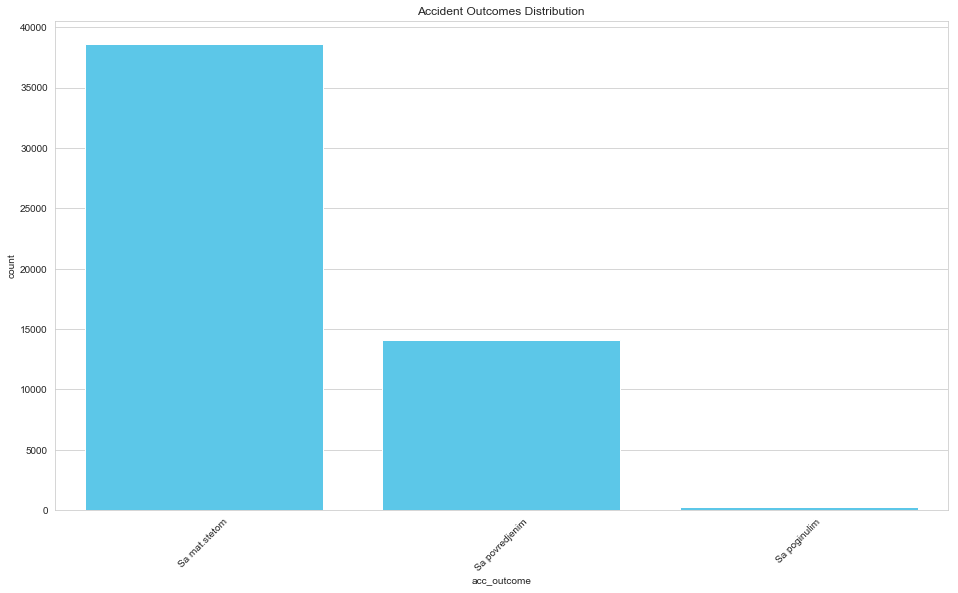

In [104]:
#Plot
order = df['acc_outcome'].value_counts().index

ax = sns.countplot(df['acc_outcome'], order=order, color=blue);

ax.set_title('Accident Outcomes Distribution')
plt.xticks(rotation=45);

In [105]:
df['acc_outcome'].value_counts()

Sa mat.stetom     38600
Sa povredjenim    14098
Sa poginulim        286
Name: acc_outcome, dtype: int64

In [106]:
#df[df['acc_outcome'] == 'Sa poginulim'].sample(5, random_state=23)

## Accident Types

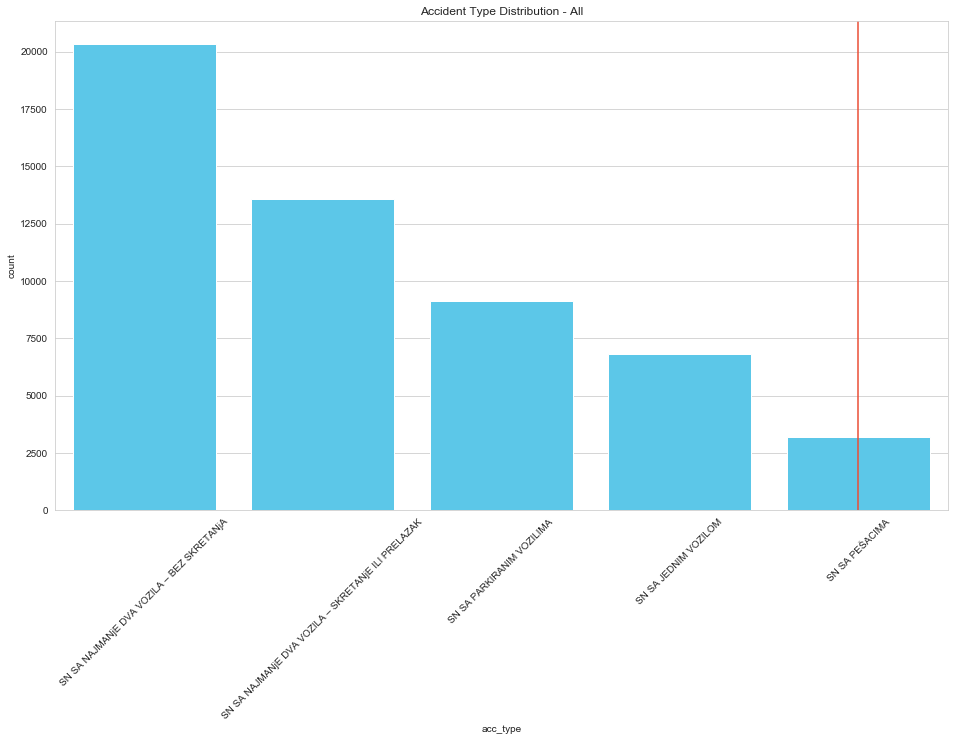

In [107]:
#Plot
order = df['acc_type'].value_counts().index

ax = sns.countplot(df['acc_type'], order=order, color=blue);

ax.set_title('Accident Type Distribution - All')
plt.xticks(rotation=45);

plt.gca().axvline(df['acc_type'].nunique() - 1, color = coral);

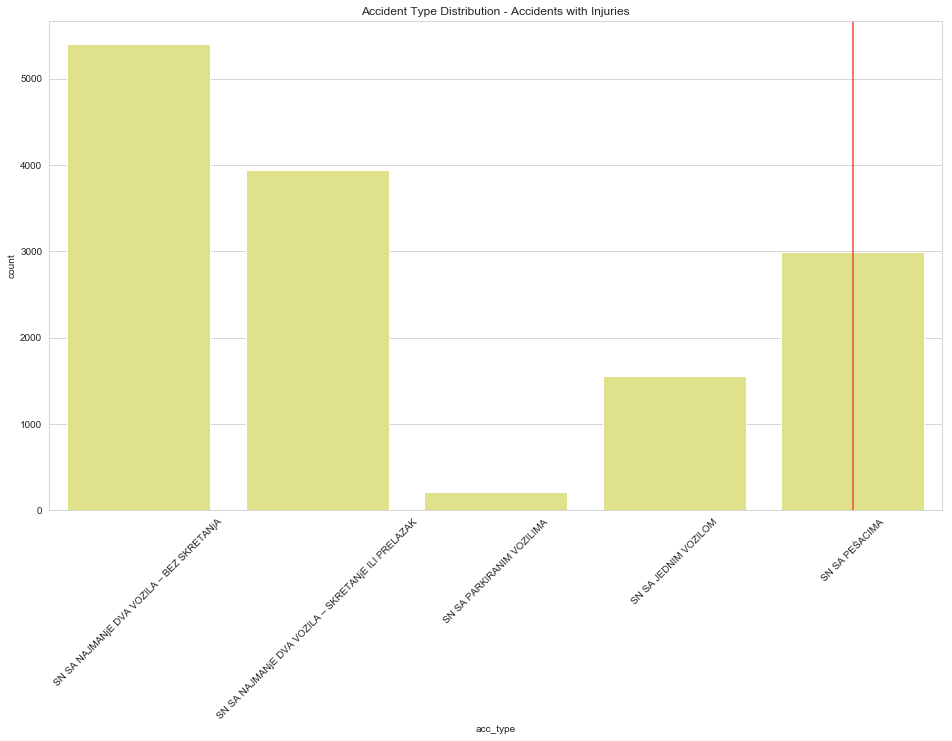

In [108]:
#Plot
topl = df[df['acc_outcome'] == 'Sa povredjenim']
order = df['acc_type'].value_counts().index

ax = sns.countplot(topl['acc_type'], order=order, color=yellow);

ax.set_title('Accident Type Distribution - Accidents with Injuries')
plt.xticks(rotation=45);

plt.gca().axvline(df['acc_type'].nunique() - 1, color = coral);

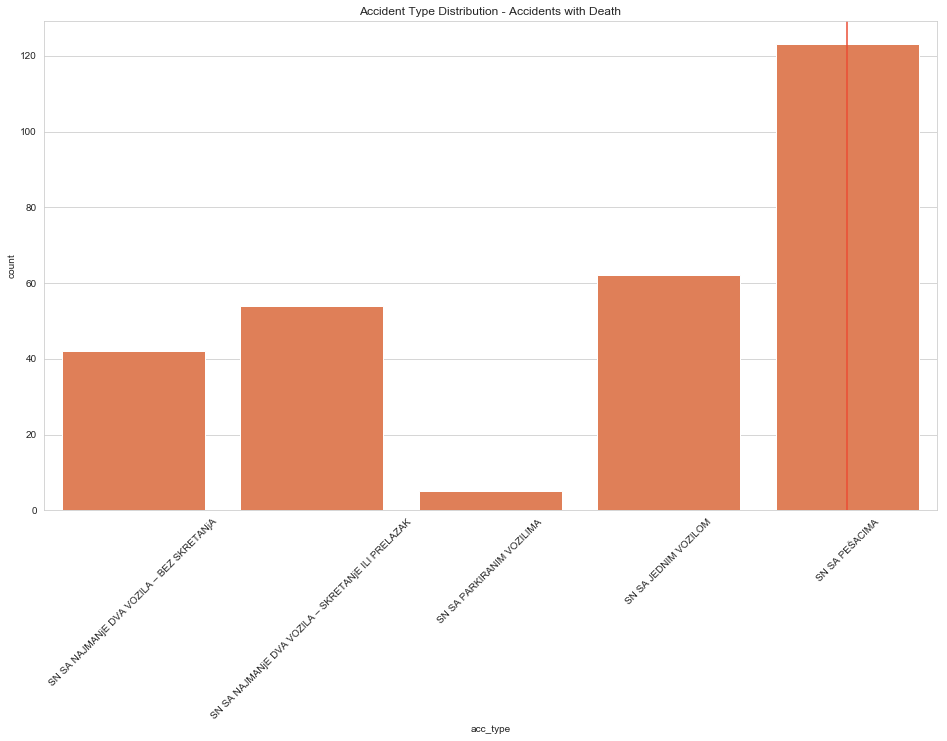

In [109]:
#Plot
topl = df[df['acc_outcome'] == 'Sa poginulim']
order = df['acc_type'].value_counts().index

ax = sns.countplot(topl['acc_type'], order=order, color=peach);

ax.set_title('Accident Type Distribution - Accidents with Death')
plt.xticks(rotation=45);

plt.gca().axvline(df['acc_type'].nunique() - 1, color = coral);

**Red Line** marks **pedestrians**. <br/>
    Although the accidents with pedestrians are the **least common**, they have the **highest death toll**. 

## Accident Descriptions

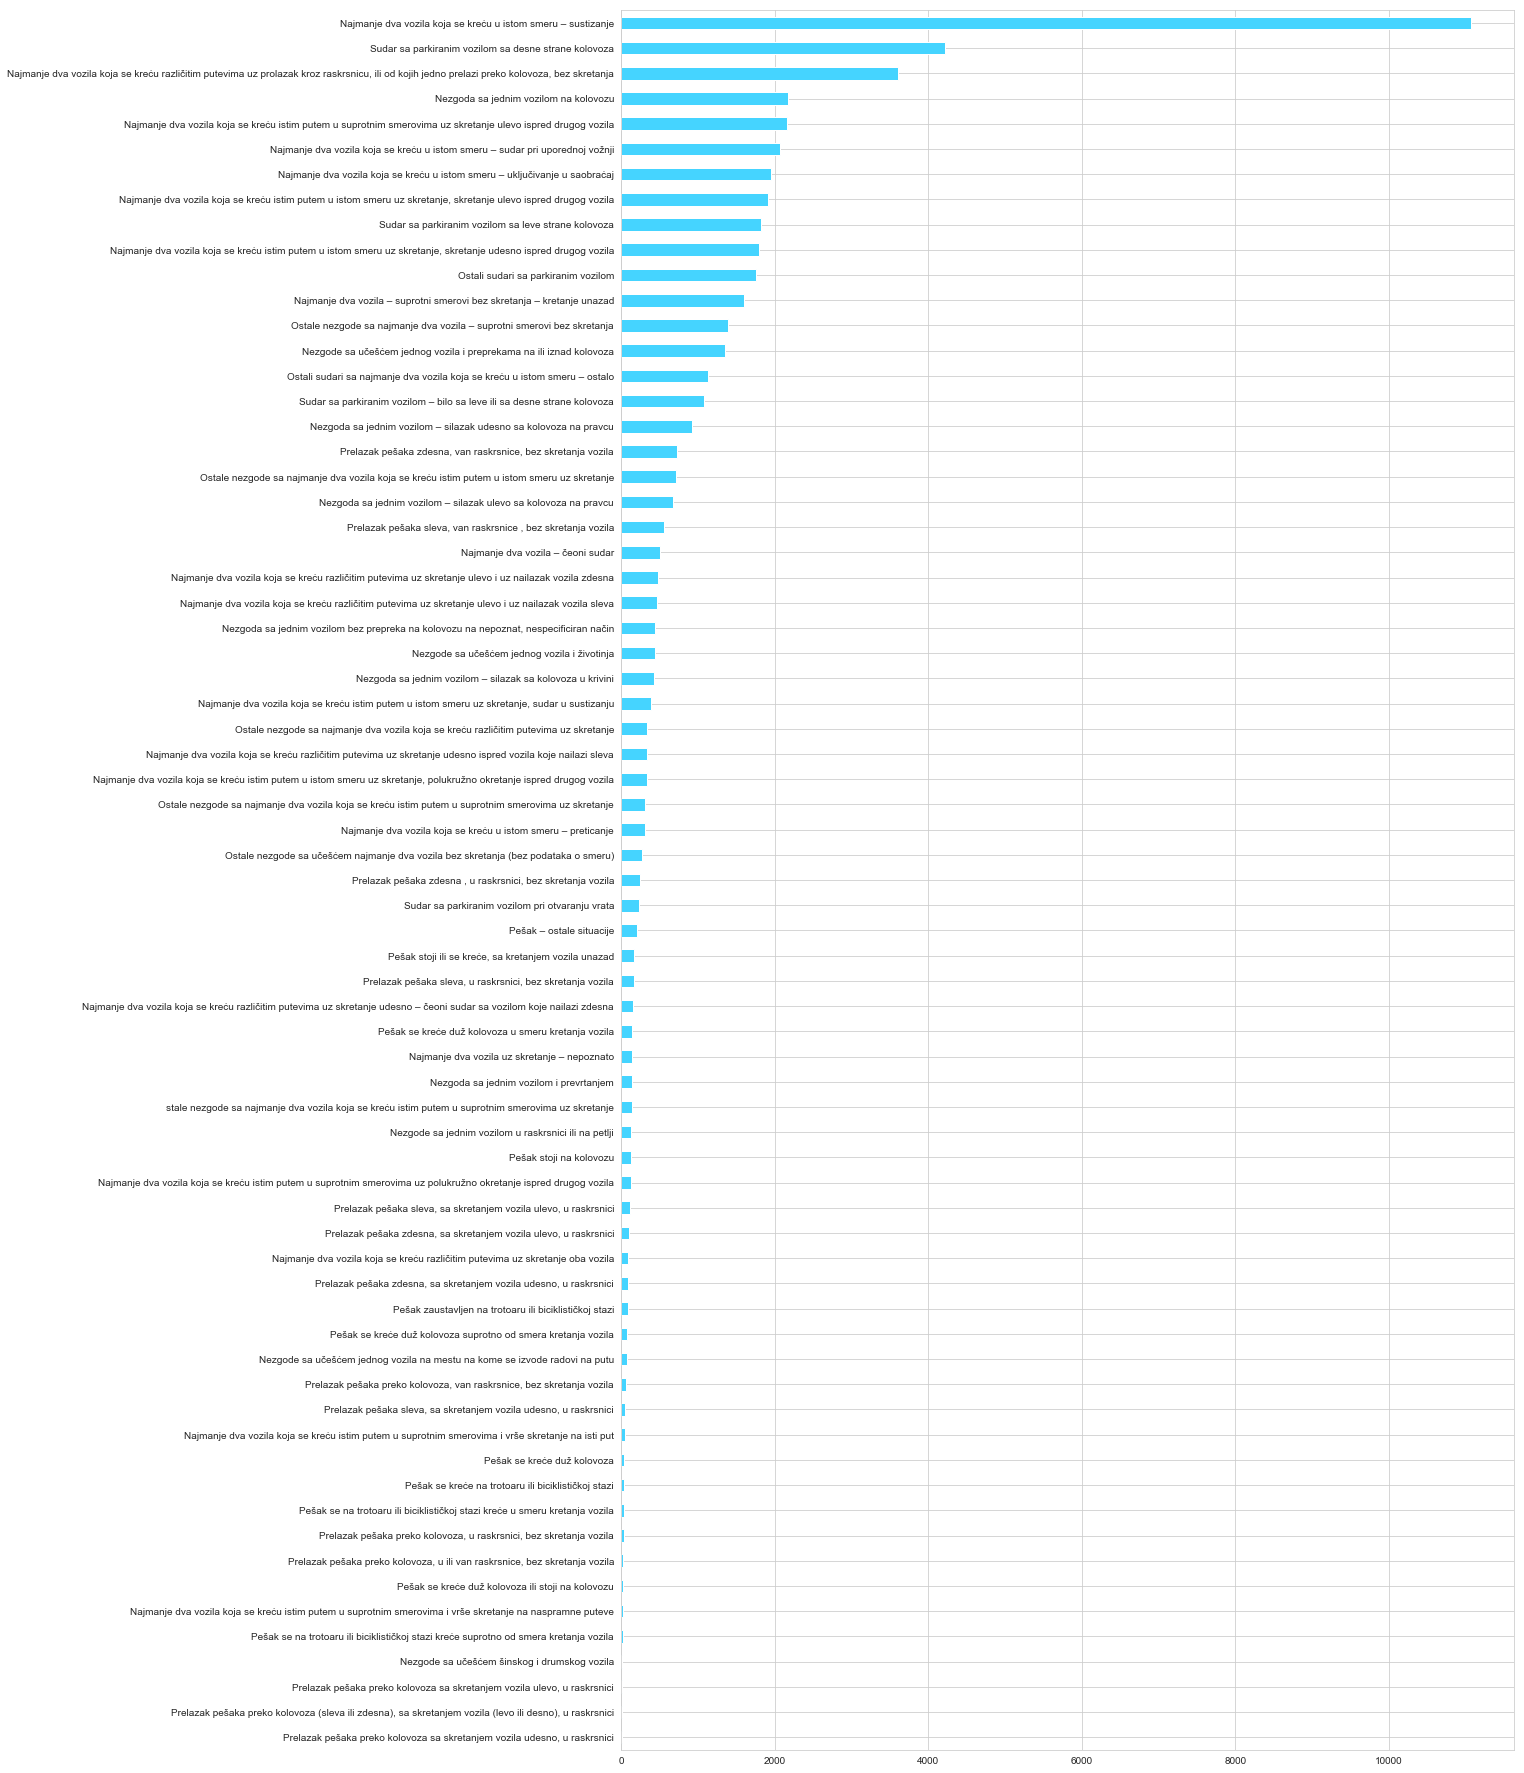

In [110]:
plt.figure(figsize=(pw, 2*pw))
df['description'].value_counts()[::-1].plot(kind='barh', color=blue);

##  Time Series - Trend and Seasonality Observations

In [111]:
#Seasonal df
ts_df = df.set_index('date')

#Resample
ts_df = ts_df.resample('1m')[['count']].sum()

#Trend and Season
ts_df['trend'] = ts_df[['count']].rolling(12).mean()
ts_df['residual'] = ts_df['count'] - ts_df['trend']

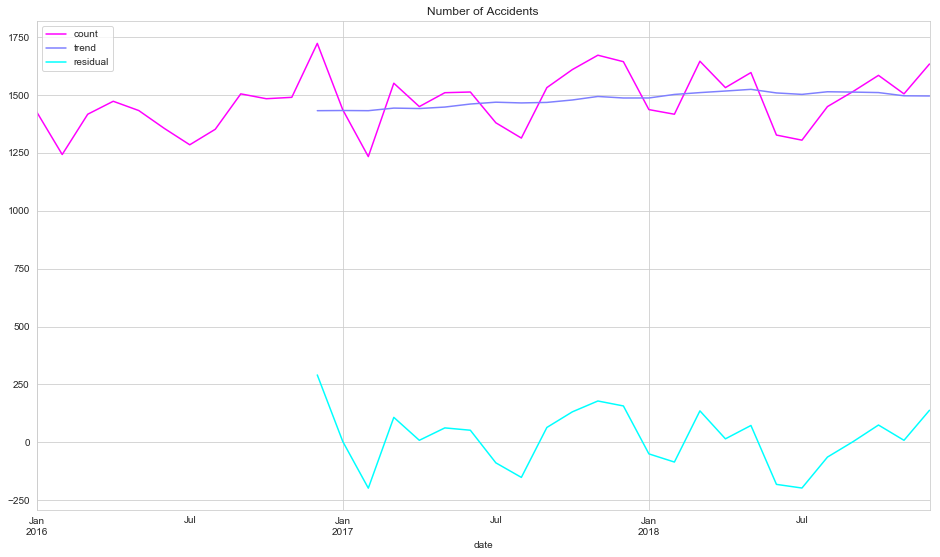

In [112]:
#Plot
ax = ts_df.plot(colormap='cool_r');

ax.set_title('Number of Accidents');

**Notes**
- We can observe that the number of accidents is **slightly rising** each year
- There might be **missing data** for 2015 Nov - 2016 Jan
- 2019 data looks **odd**
- There is still seasonality left in residual (monthly seson.)

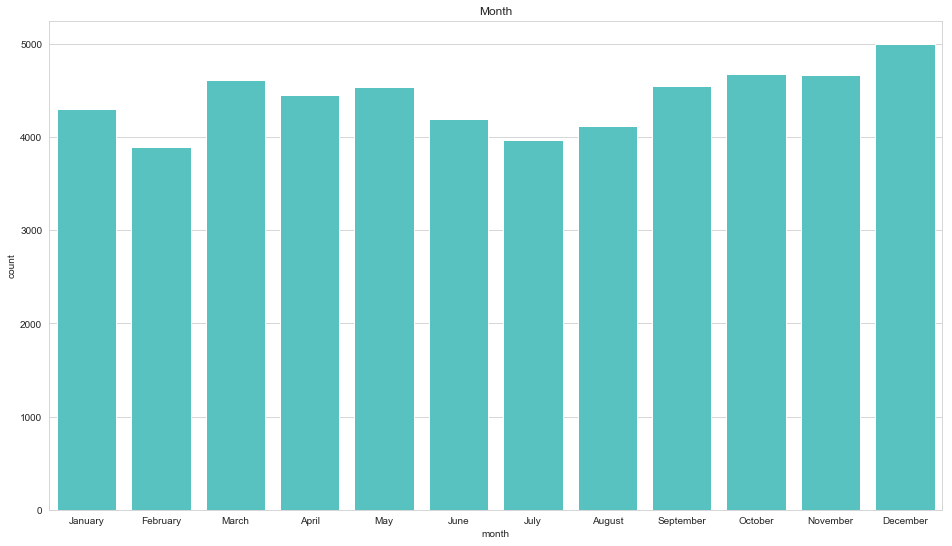

In [113]:
#Month
ax = sns.countplot(df['month'], color=aquam);

ax.set_title('Month');

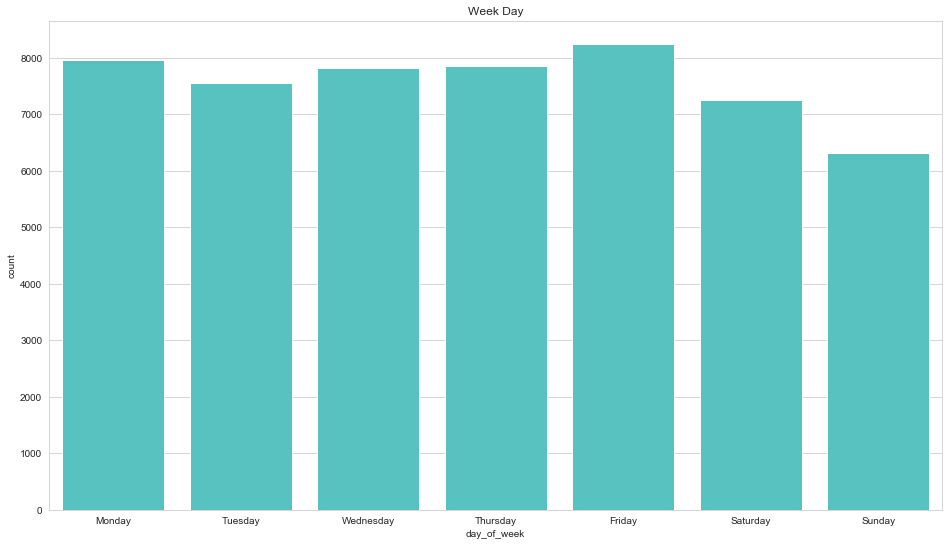

In [114]:
#Month
order = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.countplot(df['day_of_week'], order=order, color=aquam);

ax.set_title('Week Day');

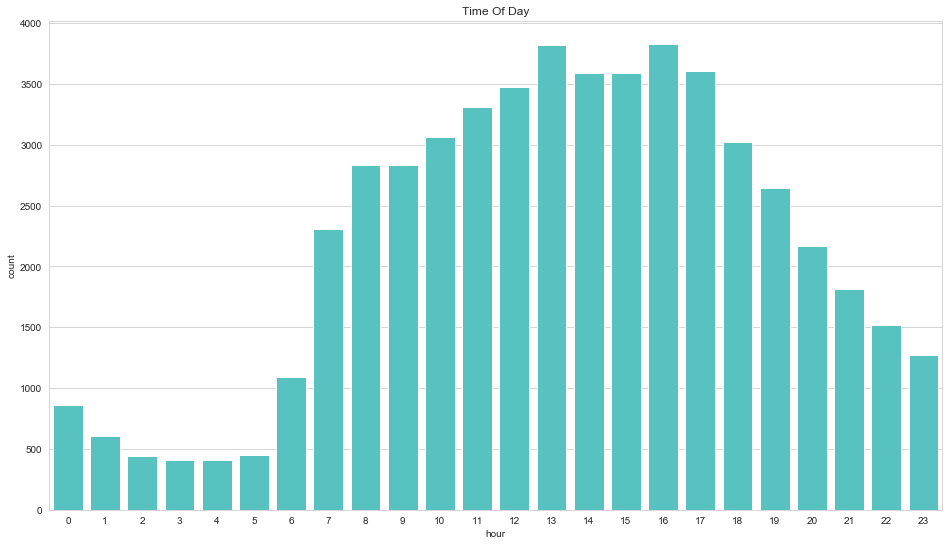

In [115]:
#Month
ax = sns.countplot(df['hour'], color=aquam);

ax.set_title('Time Of Day');

In [138]:
#critical dates?

## GeoLoc 

In [116]:
#Constant
belgrade_loc = {'lat':'44.7866', 'long':'20.4489'}

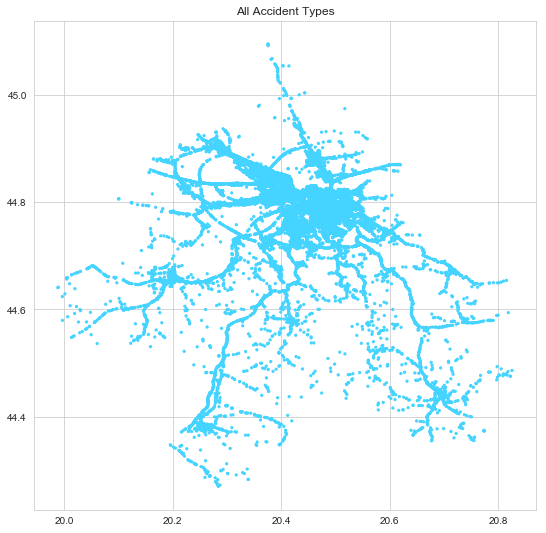

In [117]:
plt.figure(figsize=(ph, ph))

plt.scatter(df['long'], df['lat'], s=[5] * len(df), color=blue);
plt.title("All Accident Types");

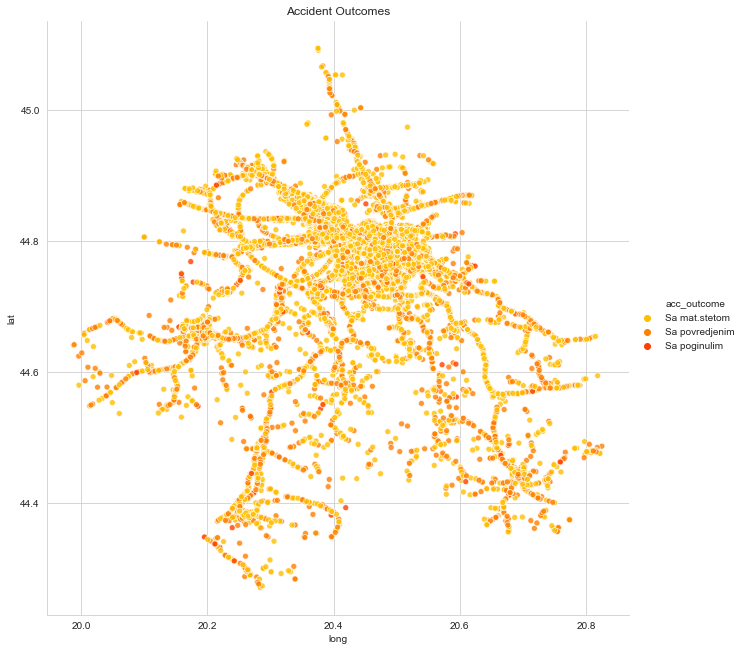

In [118]:
sns.relplot(x="long", y="lat", hue="acc_outcome", alpha=.8, palette="autumn_r", height=ph, data=df);

plt.title("Accident Outcomes");

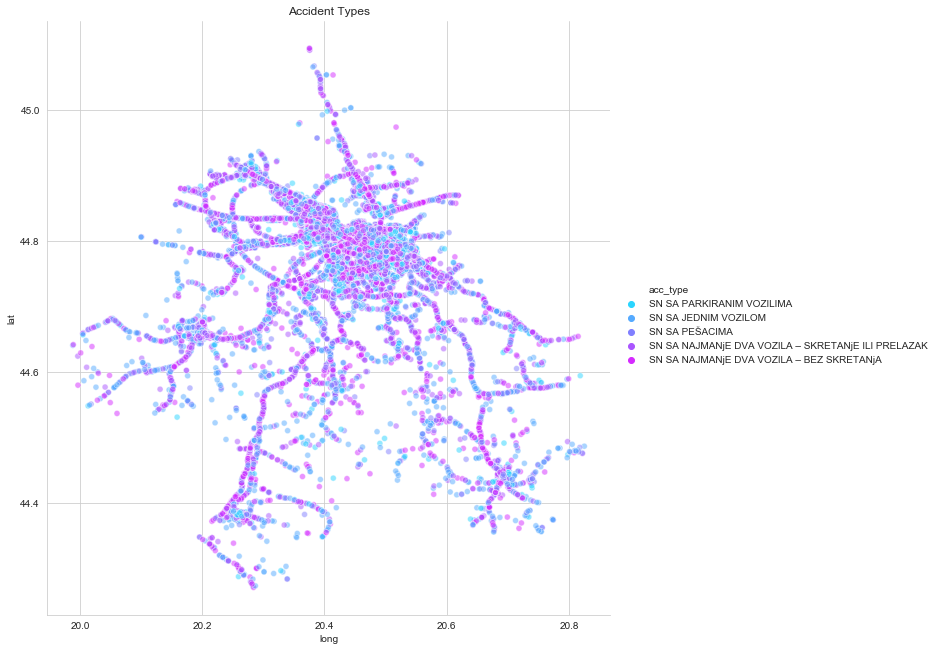

In [119]:
sns.relplot(x="long", y="lat", hue="acc_type", alpha=.5, palette="cool", height=ph, data=df);

plt.title("Accident Types");

In [120]:
from gmplot import gmplot

from IPython.core.display import display, HTML
from IPython.display import IFrame

In [121]:
#Create Heatmap
gmap = gmplot.GoogleMapPlotter(belgrade_loc['lat'],belgrade_loc['long'], zoom=10);

heatmap = gmap.heatmap(df['lat'], df['long'], radius=20)

hm_output = output_dir + "accidents_heatmap.html"
gmap.draw(hm_output)

In [122]:
#Display Map
#IFrame(src=hm_output, width=800, height=800)

**HTML** Available in **outputs** folder

## Traffic Circle Slavija  - Case Study

- **pre_rec** - 1 year period before reconstruction
- **post_rec** - 1 year period after reconstruction

In [123]:
#Slavija coordinates
lat_1, long_1 = 44.803230, 20.465422
lat_2, long_2 = 44.802029, 20.467424

#Is Slavija
df['is_slavija'] = df['lat'].between(lat_2,lat_1) & df['long'].between(long_1, long_2)

In [124]:
#Reconstruction Dates
rec_start = datetime.datetime(2017, 5, 1)
rec_end = datetime.datetime(2017, 12, 1)

pre_rec_start = rec_start - datetime.timedelta(days=365)
pre_rec_end = rec_start

post_rec_start = rec_end
post_rec_end = rec_end + datetime.timedelta(days=365)

#Reconstruction Period
def get_period(date):
    if date >= pre_rec_start and date <= pre_rec_end:
        return "pre_rec"
    elif date >= post_rec_start and date <= post_rec_end:
        return "post_rec"
    else:
        return "other"

df['pre_post_rec'] = df['date'].map(get_period)

In [125]:
#Slavija pre and post reconstruction
sl_df = df[df['is_slavija'] & (df['pre_post_rec'] != 'other') ]

pp_df = df[df['pre_post_rec'] != 'other']

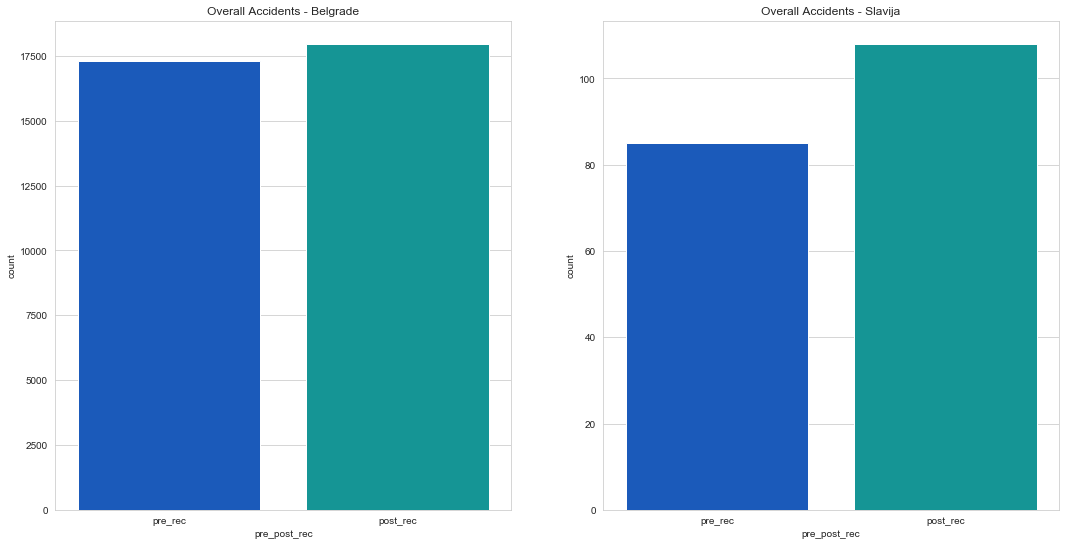

In [126]:
f, ax = plt.subplots(1, 2, figsize=(2*ph, ph))

#Overall
sns.countplot(pp_df['pre_post_rec'], ax=ax[0],  palette="winter")

ax[0].set_title("Overall Accidents - Belgrade");

#Overall
sns.countplot(sl_df['pre_post_rec'], ax=ax[1], palette="winter")

ax[1].set_title("Overall Accidents - Slavija");

In [127]:
post_c = sl_df['pre_post_rec'].value_counts()[0]
pre_c = sl_df['pre_post_rec'].value_counts()[1]
x  = pre_c 
n = post_c + pre_c
res = binom_test(x, n, alternative='less')
print ('C-Test for increase in number of accidents {:.2f} p-val'.format(res))

C-Test for increase in number of accidents 0.06 p-val


**p-val above** general acceptance threshold. 

**Notes** 
- We can observe increase in the number of accidents on Slavija after reconstruction (right hand side)
- General rise in the number of accident in Belgrade contributes only partially (left hand side)

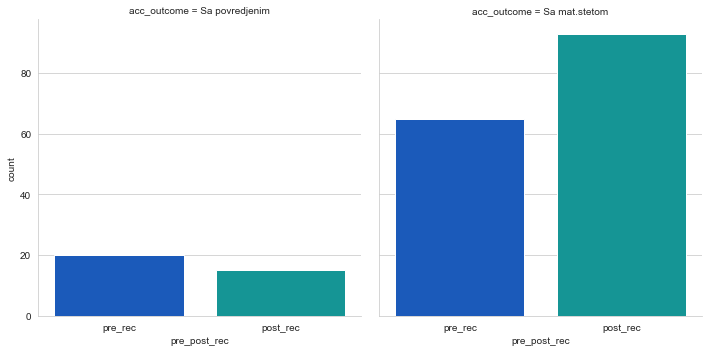

In [129]:
sns.catplot(x="pre_post_rec", y='count', col="acc_outcome", data=sl_df, kind="bar", estimator=sum, palette="winter",);

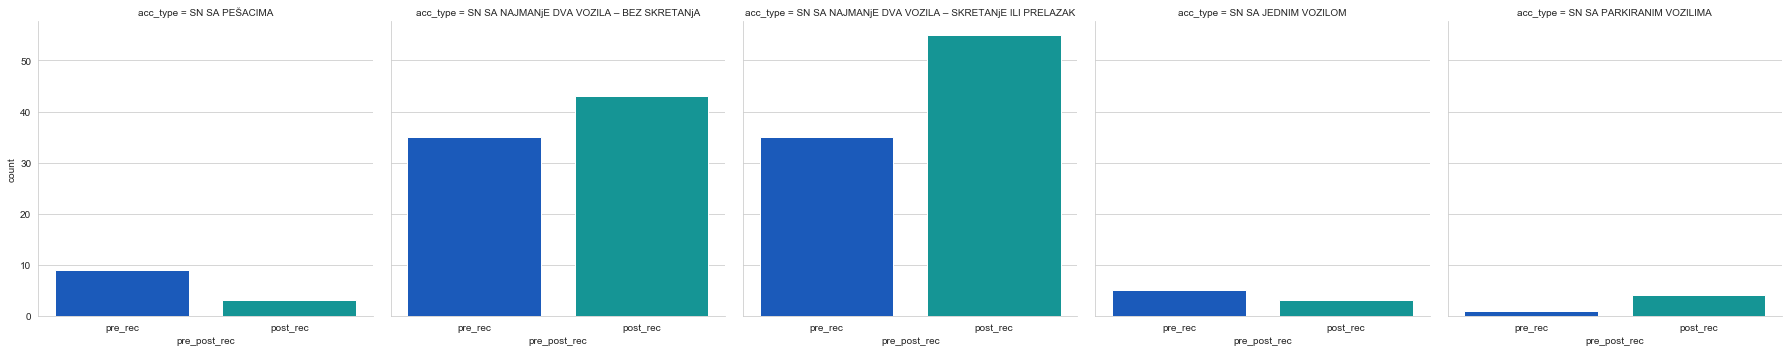

In [130]:
sns.catplot(x="pre_post_rec", y='count', col="acc_type", data=sl_df, kind="bar", estimator=sum, palette="winter");

**Notes**
1. **Less** accidents with **injuries**
2. **Less** accidents with **pedestrians** - this contributes to 1.
3. **Increased** number of accidents with multiple vehicles 
4. There were **no accidents** on Slavija with deadly outcomes (for these two years)

In [131]:
#Create ts dataframe
topl = sl_df.copy()

#Shift Year
topl['date_shf'] = topl['date'].map(lambda x : x.replace(year=2019))

topl = topl.set_index('date_shf')

#Pre/Post
topl['pre_rec'] = (topl['pre_post_rec'] == 'pre_rec').astype(int)
topl['post_rec'] = (topl['pre_post_rec'] == 'post_rec').astype(int)

topl = topl[['pre_rec', 'post_rec']].resample('1m').sum()

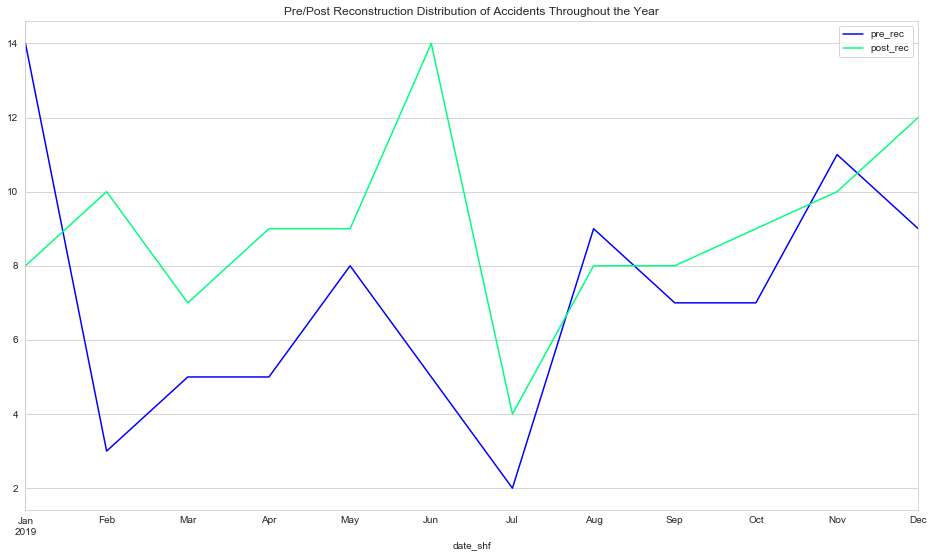

In [132]:
ax = topl.plot( cmap="winter");

ax.set_title("Pre/Post Reconstruction Distribution of Accidents Throughout the Year");

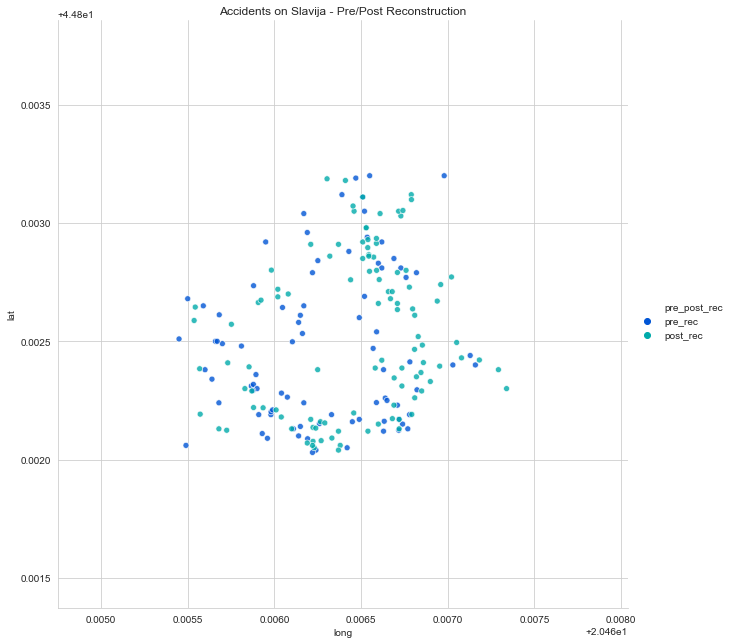

In [133]:
topl = sl_df

sns.relplot(x="long", y="lat", hue="pre_post_rec", alpha=.8, palette="winter", height=ph, data=topl);

plt.title("Accidents on Slavija - Pre/Post Reconstruction");

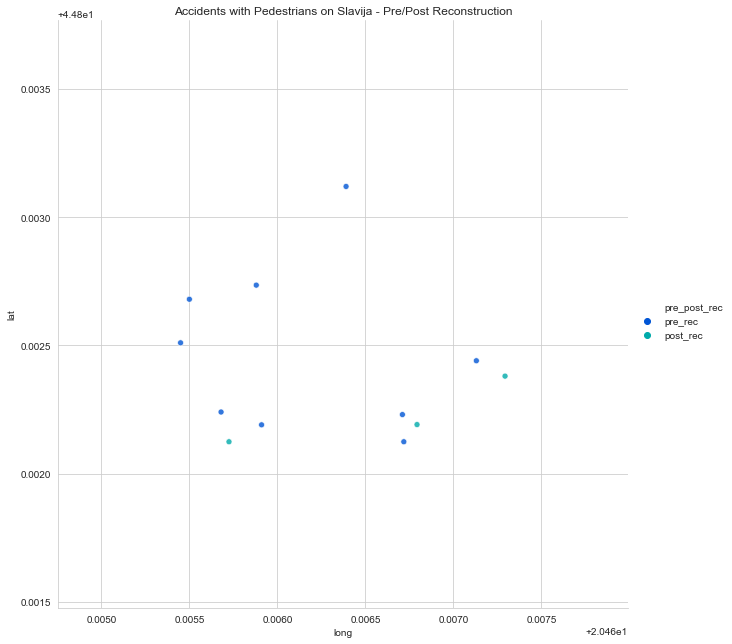

In [134]:
topl = sl_df[sl_df['acc_type'] == 'SN SA PEŠACIMA']

sns.relplot(x="long", y="lat", hue="pre_post_rec", alpha=.8, palette="winter", height=ph, data=topl);

plt.title("Accidents with Pedestrians on Slavija - Pre/Post Reconstruction");

## Parking Lot Obilicev Venac

In [135]:
#OV coordinates
lat_1, long_1 = 44.816212, 20.456927
lat_2, long_2 = 44.815384, 20.457687

#Is Slavija
pl_df = df[df['lat'].between(lat_2,lat_1) & df['long'].between(long_1, long_2)]

print("Number of accidents on Obilicev Venac parking lot {}".format(len(pl_df)))

Number of accidents on Obilicev Venac parking lot 72


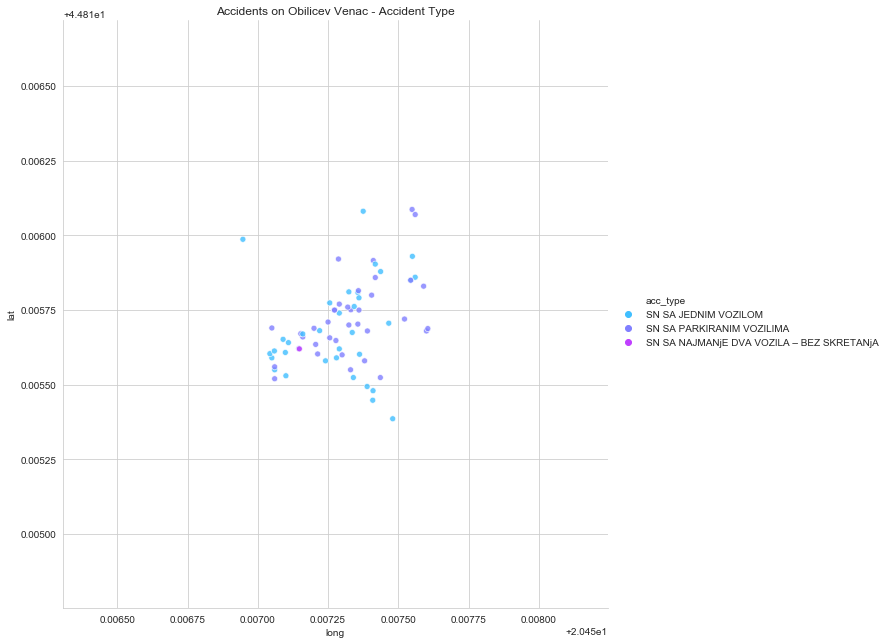

In [136]:
topl = pl_df

sns.relplot(x="long", y="lat", hue="acc_type", alpha=.8, palette="cool", height=ph, data=topl);

plt.title("Accidents on Obilicev Venac - Accident Type");

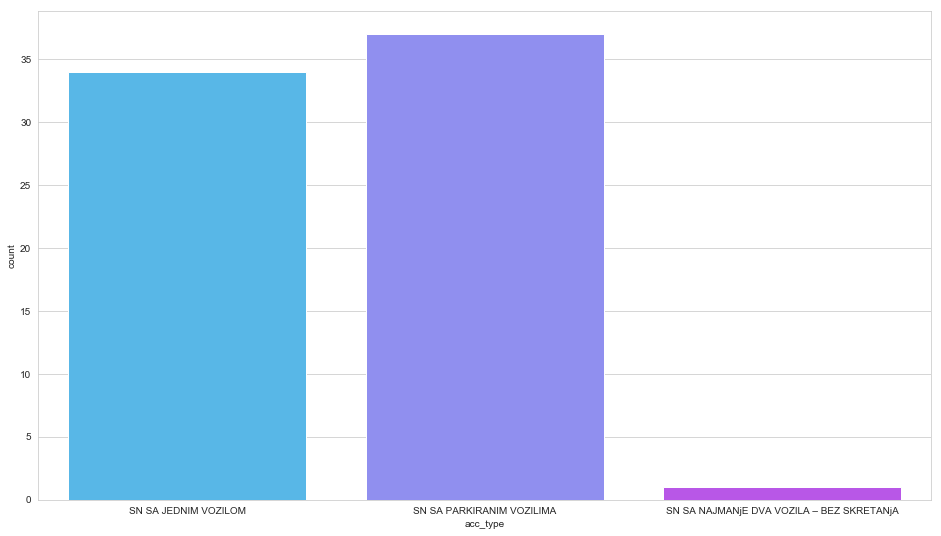

In [137]:
sns.countplot(pl_df['acc_type'], palette='cool');

Almost all accidents are with **parked cars** or **single car**.